In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib


In [3]:
# Load dataset
file_path = "alzheimers_disease_data.csv"  # Update with actual file path
data = pd.read_csv(file_path)

In [4]:
# Display basic info
data.info()
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        1000 non-null   int64  
 1   Gender     1000 non-null   object 
 2   APOE4      1000 non-null   int64  
 3   MMSE       1000 non-null   float64
 4   Diagnosis  1000 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB
               Age        APOE4         MMSE
count  1000.000000  1000.000000  1000.000000
mean     74.178000     0.522000    24.991781
std       8.768877     0.499766     5.022794
min      60.000000     0.000000    11.527575
25%      66.000000     0.000000    21.577122
50%      74.000000     1.000000    25.047718
75%      82.000000     1.000000    28.256981
max      89.000000     1.000000    42.527368
   Age  Gender  APOE4       MMSE Diagnosis
0   72    Male      0  28.711058        AD
1   75    Male      0  28.989227       MCI
2   81    Male    

In [5]:
# Handle missing values (if any)
data = data.dropna()

In [6]:
# Encode categorical variables (if applicable)
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [7]:
# Split features and target
X = data.drop(columns=["Diagnosis"])  # Replace with actual target column name
y = data["Diagnosis"]


In [8]:
# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [9]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [11]:
# Best model
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
# Additional model
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)


GradientBoostingClassifier(n_estimators=200, random_state=42)

In [13]:
# Predictions
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = gb.predict(X_test)


In [14]:
# Model Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
rf_report = classification_report(y_test, y_pred_rf)
gb_report = classification_report(y_test, y_pred_gb)
rf_confusion = confusion_matrix(y_test, y_pred_rf)
gb_confusion = confusion_matrix(y_test, y_pred_gb)

results = f"""
Random Forest Performance:
Accuracy: {rf_accuracy:.2f}
Classification Report:
{rf_report}
Confusion Matrix:
{rf_confusion}

Gradient Boosting Performance:
Accuracy: {gb_accuracy:.2f}
Classification Report:
{gb_report}
Confusion Matrix:
{gb_confusion}
"""

with open("model_results.txt", "w") as file:
    file.write(results)

print(results)


Random Forest Performance:
Accuracy: 0.28
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.22      0.24        63
           1       0.33      0.37      0.35        73
           2       0.26      0.25      0.25        64

    accuracy                           0.28       200
   macro avg       0.28      0.28      0.28       200
weighted avg       0.28      0.28      0.28       200

Confusion Matrix:
[[14 26 23]
 [23 27 23]
 [19 29 16]]

Gradient Boosting Performance:
Accuracy: 0.30
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.32      0.31        63
           1       0.30      0.32      0.31        73
           2       0.28      0.27      0.27        64

    accuracy                           0.30       200
   macro avg       0.30      0.30      0.30       200
weighted avg       0.30      0.30      0.30       200

Confusion Matrix:
[[20 25 18]
 [25 23 25]
 [19 

Random Forest AUC: 0.47
Gradient Boosting AUC: 0.46


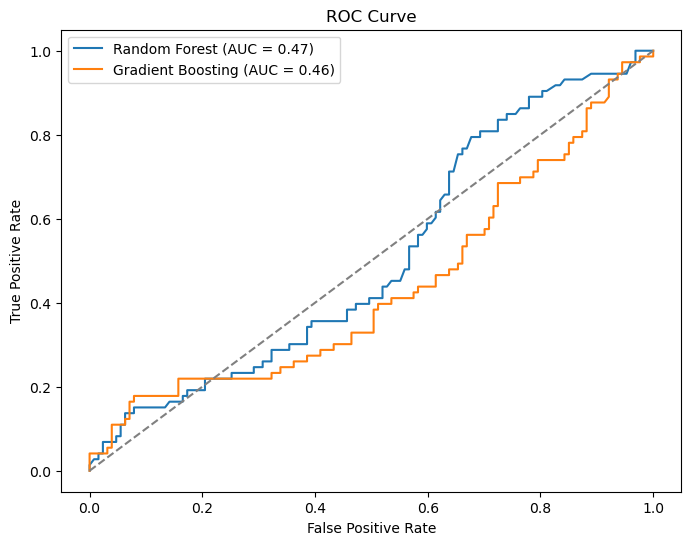

In [15]:
# ROC Curve
rf_probs = best_rf.predict_proba(X_test)
gb_probs = gb.predict_proba(X_test)

rf_auc = roc_auc_score(y_test, rf_probs, multi_class='ovr')
gb_auc = roc_auc_score(y_test, gb_probs, multi_class='ovr')

print(f"Random Forest AUC: {rf_auc:.2f}")
print(f"Gradient Boosting AUC: {gb_auc:.2f}")

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs[:, 1], pos_label=best_rf.classes_[1])
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probs[:, 1], pos_label=gb.classes_[1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [16]:
# Save the models
joblib.dump(best_rf, "best_rf_model.pkl")
joblib.dump(gb, "gb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")


['label_encoders.pkl']